# E-Commerce Data Cleaning

## Goal
Prepare raw transaction-level e-commerce data for SQL-based analytics by
cleaning invalid records and creating revenue-related features.

## Load Raw Dataset

The dataset contains transaction-level records from a UK-based online retailer.
Each row represents a single product line item within an invoice.

In [1]:
import pandas as pd

df = pd.read_csv("../data/raw.csv", encoding="ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Inspect Dataset Structure

We begin by examining the dataset’s structure, including:
- column names and data types
- number of non-null values
- overall dataset size

This step helps identify potential data quality issues early.

In [2]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  str    
 1   StockCode    541909 non-null  str    
 2   Description  540455 non-null  str    
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  str    
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  str    
dtypes: float64(2), int64(1), str(5)
memory usage: 33.1 MB


## Summary Statistics

Summary statistics provide insight into:
- numeric ranges
- presence of extreme values
- potential invalid or unexpected entries

In [3]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Column Overview

Listing column names allows us to confirm:
- expected fields are present
- naming consistency
- which columns will be used in downstream analytics

In [4]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='str')

## Initial Observations

- The dataset contains transaction-level e-commerce records.
- Each row represents a product-level line item within an invoice.
- Some columns contain missing values, particularly CustomerID.
- Quantity and UnitPrice include non-positive values, which may indicate returns or cancellations.
- InvoiceDate includes timestamp information suitable for time-based analysis.

## Missing Values Check

We check for missing values across all columns to understand
where data may need to be filtered, imputed, or handled carefully.

In [5]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Invalid Quantity and Price Values

Transactions with non-positive quantity or unit price may represent:
- returns
- cancellations
- data entry errors

These must be handled explicitly during cleaning.

In [6]:
(df["Quantity"] <= 0).sum(), (df["UnitPrice"] <= 0).sum()

(np.int64(10624), np.int64(2517))

## Cancelled Invoices

Invoices beginning with the letter "C" typically indicate cancelled orders.
We quantify these to decide how they should be handled during cleaning.

In [7]:
df["InvoiceNo"].astype(str).str.startswith("C").sum()

np.int64(9288)

## Stop Point

At this stage, no cleaning has been performed.
The purpose of this notebook section is to fully understand the raw data
before making any modifications.

Next steps will include:
- removing cancelled orders
- handling returns and negative quantities
- addressing missing customer identifiers
- creating revenue-related features


## Data Cleaning Strategy

The goal of cleaning is not to maximize row count, but to produce reliable and interpretable business metrics.

Cleaning decisions are guided by:
- revenue accuracy
- customer-level analysis needs
- consistency with real-world e-commerce processes

Each cleaning step is applied incrementally and validated before proceeding.

## Create a Working Copy

We preserve the raw dataset by creating a working copy.
All cleaning operations are applied to the copy only.

In [8]:
df_clean = df.copy()

## Identify Cancelled Orders

Invoices starting with the letter "C" indicate cancelled transactions.
These should not be included in revenue or customer behavior analysis.

In [9]:
df_clean["is_cancelled"] = df_clean["InvoiceNo"].astype(str).str.startswith("C")

df_clean["is_cancelled"].value_counts()

is_cancelled
False    532621
True       9288
Name: count, dtype: int64

## Identify Returns

Negative quantities indicate returned items.
Returns will be tracked separately from purchases.

In [10]:
df_clean["is_return"] = df_clean["Quantity"] < 0

df_clean["is_return"].value_counts()

is_return
False    531285
True      10624
Name: count, dtype: int64

## Identify Invalid Unit Prices

Non-positive unit prices are invalid for revenue calculations
and must be handled before computing revenue.

In [11]:
(df_clean["UnitPrice"] <= 0).sum()

np.int64(2517)

## Cleaning Decisions (Planned)

Based on inspection, we will apply the following rules:

1. Remove cancelled invoices entirely
2. Exclude rows with non-positive unit prices
3. Retain returns but track them separately
4. Retain rows with missing CustomerID for revenue analysis,
   but exclude them from customer-level metrics


## Remove Cancelled Orders and Invalid Prices

Cancelled orders and invalid prices are removed to ensure
revenue calculations reflect completed transactions only.

In [12]:
initial_rows = len(df_clean)

df_clean = df_clean[~df_clean["is_cancelled"]]
df_clean = df_clean[df_clean["UnitPrice"] > 0]

len(df_clean), initial_rows

(530104, 541909)

## Create Revenue Feature

Revenue is calculated at the line-item level as:
Quantity × UnitPrice.

Returns will naturally produce negative revenue values.

In [13]:
df_clean["line_revenue"] = df_clean["Quantity"] * df_clean["UnitPrice"]

df_clean[["Quantity", "UnitPrice", "line_revenue"]].head()

,Quantity,UnitPrice,line_revenue
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


## Stop Point

At this stage:
- Cancelled orders have been removed
- Invalid prices have been excluded
- Returns are explicitly flagged
- Revenue has been computed safely

The dataset is now suitable for customer-level and time-based analysis.

Next steps will include:
- handling missing CustomerID values
- creating clean date features
- preparing SQL-ready tables

In [14]:
df_clean.shape

(530104, 11)

In [15]:
df_clean["is_return"].sum()

np.int64(0)

In [16]:
df_clean["CustomerID"].isna().sum()

np.int64(132220)

## CustomerID Handling Strategy

CustomerID is missing for a significant portion of transactions.

To preserve analytical integrity:
- All transactions will be retained for revenue-based metrics
- Only transactions with valid CustomerID will be used for
  customer-level analysis (e.g., retention, cohorts, RFM)

This approach reflects real-world analytics practices where
revenue reporting and customer analytics serve different purposes.

In [17]:
df_revenue = df_clean.copy()
df_customers = df_clean[df_clean["CustomerID"].notna()].copy()

df_revenue.shape, df_customers.shape

((530104, 11), (397884, 11))

In [18]:
df_revenue.shape

(530104, 11)

In [19]:
df_customers.shape

(397884, 11)

## Create Time-Based Features

To support SQL-based reporting and time-series analysis,
we create standardized date features from InvoiceDate.

These fields will enable:
- daily and monthly revenue reporting
- cohort and retention analysis
- time-based aggregations in SQL

In [20]:
# Convert InvoiceDate to datetime
df_revenue["InvoiceDate"] = pd.to_datetime(df_revenue["InvoiceDate"])
df_customers["InvoiceDate"] = pd.to_datetime(df_customers["InvoiceDate"])

# Create time features
for df_ in [df_revenue, df_customers]:
    df_["invoice_date"] = df_["InvoiceDate"].dt.date
    df_["invoice_month"] = df_["InvoiceDate"].dt.to_period("M").astype(str)
    df_["invoice_year"] = df_["InvoiceDate"].dt.year

In [21]:
df_revenue[["InvoiceDate", "invoice_date", "invoice_month"]].head()

,InvoiceDate,invoice_date,invoice_month
0,2010-12-01 08:26:00,2010-12-01,2010-12
1,2010-12-01 08:26:00,2010-12-01,2010-12
2,2010-12-01 08:26:00,2010-12-01,2010-12
3,2010-12-01 08:26:00,2010-12-01,2010-12
4,2010-12-01 08:26:00,2010-12-01,2010-12


In [22]:
df_revenue[["invoice_date", "invoice_month"]].head()

,invoice_date,invoice_month
0,2010-12-01,2010-12
1,2010-12-01,2010-12
2,2010-12-01,2010-12
3,2010-12-01,2010-12
4,2010-12-01,2010-12


## Define Orders

In this dataset, each order is identified by a unique InvoiceNo.
Multiple rows may exist per order due to multiple products.

All order-level metrics will be based on distinct InvoiceNo values.

## Monthly Revenue KPIs

We aggregate transaction-level data into monthly business KPIs:
- total orders
- gross revenue
- returns
- net revenue
- average order value (AOV)

This table mirrors what would be produced in SQL for dashboards or BI tools.

In [23]:
monthly_kpis = (
    df_revenue
    .groupby("invoice_month")
    .agg(
        orders=("InvoiceNo", "nunique"),
        gross_revenue=("line_revenue", lambda x: x[x > 0].sum()),
        returns=("line_revenue", lambda x: x[x < 0].sum()),
        net_revenue=("line_revenue", "sum")
    )
    .reset_index()
)

monthly_kpis["aov"] = monthly_kpis["net_revenue"] / monthly_kpis["orders"]

monthly_kpis.head()

,invoice_month,orders,gross_revenue,returns,net_revenue,aov
0,2010-12,1559,823746.140,0.0,823746.140,528.381103
1,2011-01,1086,691364.560,0.0,691364.560,636.615617
2,2011-02,1100,523631.890,0.0,523631.890,476.028991
3,2011-03,1454,717639.360,0.0,717639.360,493.562146
4,2011-04,1246,537808.621,0.0,537808.621,431.628107


## Returns Handling Note

In this analysis, cancelled invoices (InvoiceNo starting with "C")
were removed entirely during cleaning.

As a result, returned transactions recorded as cancellations
are excluded from revenue KPIs.

This reflects a business assumption where cancellations and refunds
are handled outside core sales performance reporting.

## Customer-Level Metrics

To analyze customer behavior, we aggregate transaction-level data
to the customer level.

Metrics created in this step include:
- number of orders per customer
- total revenue per customer
- first and most recent purchase dates

These features form the foundation for retention, cohort,
and segmentation analysis.

In [24]:
customer_summary = (
    df_customers
    .groupby("CustomerID")
    .agg(
        total_orders=("InvoiceNo", "nunique"),
        total_revenue=("line_revenue", "sum"),
        first_purchase=("InvoiceDate", "min"),
        last_purchase=("InvoiceDate", "max")
    )
    .reset_index()
)

customer_summary.head()

,CustomerID,total_orders,total_revenue,first_purchase,last_purchase
0,12346.0,1,77183.60,2011-01-18 10:01:00,2011-01-18 10:01:00
1,12347.0,7,4310.00,2010-12-07 14:57:00,2011-12-07 15:52:00
2,12348.0,4,1797.24,2010-12-16 19:09:00,2011-09-25 13:13:00
3,12349.0,1,1757.55,2011-11-21 09:51:00,2011-11-21 09:51:00
4,12350.0,1,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00


## Recency Feature

Recency measures how recently a customer made a purchase.
It is calculated as the number of days since the customer’s
most recent transaction.

In [25]:
analysis_date = df_customers["InvoiceDate"].max()

customer_summary["recency_days"] = (
    analysis_date - customer_summary["last_purchase"]
).dt.days

customer_summary.head()

,CustomerID,total_orders,total_revenue,first_purchase,last_purchase,recency_days
0,12346.0,1,77183.60,2011-01-18 10:01:00,2011-01-18 10:01:00,325
1,12347.0,7,4310.00,2010-12-07 14:57:00,2011-12-07 15:52:00,1
2,12348.0,4,1797.24,2010-12-16 19:09:00,2011-09-25 13:13:00,74
3,12349.0,1,1757.55,2011-11-21 09:51:00,2011-11-21 09:51:00,18
4,12350.0,1,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00,309


## Customer Summary Interpretation

- Total orders captures repeat purchasing behavior.
- Total revenue measures customer value.
- First and last purchase dates define customer lifespan.
- Recency highlights customer engagement and potential churn risk.

This table is suitable for downstream segmentation,
retention analysis, and predictive modeling.

In [26]:
customer_summary.head()

,CustomerID,total_orders,total_revenue,first_purchase,last_purchase,recency_days
0,12346.0,1,77183.60,2011-01-18 10:01:00,2011-01-18 10:01:00,325
1,12347.0,7,4310.00,2010-12-07 14:57:00,2011-12-07 15:52:00,1
2,12348.0,4,1797.24,2010-12-16 19:09:00,2011-09-25 13:13:00,74
3,12349.0,1,1757.55,2011-11-21 09:51:00,2011-11-21 09:51:00,18
4,12350.0,1,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00,309


## Cohort Definition

Customers are grouped into cohorts based on the month of their
first recorded purchase.

Cohort analysis helps measure customer retention over time.

In [27]:
# Add cohort month to customer summary
customer_summary["cohort_month"] = (
    customer_summary["first_purchase"]
    .dt.to_period("M")
    .astype(str)
)

customer_summary.head()

,CustomerID,total_orders,total_revenue,first_purchase,last_purchase,recency_days,cohort_month
0,12346.0,1,77183.60,2011-01-18 10:01:00,2011-01-18 10:01:00,325,2011-01
1,12347.0,7,4310.00,2010-12-07 14:57:00,2011-12-07 15:52:00,1,2010-12
2,12348.0,4,1797.24,2010-12-16 19:09:00,2011-09-25 13:13:00,74,2010-12
3,12349.0,1,1757.55,2011-11-21 09:51:00,2011-11-21 09:51:00,18,2011-11
4,12350.0,1,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00,309,2011-02


## Attach Cohort Information to Transactions

Cohort labels are merged back to transaction-level data
to compute retention metrics over time.

In [28]:
df_cohort = df_customers.merge(
    customer_summary[["CustomerID", "cohort_month"]],
    on="CustomerID",
    how="left"
)

df_cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_cancelled,is_return,line_revenue,invoice_date,invoice_month,invoice_year,cohort_month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,False,15.30,2010-12-01,2010-12,2010,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,False,20.34,2010-12-01,2010-12,2010,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,False,22.00,2010-12-01,2010-12,2010,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,False,20.34,2010-12-01,2010-12,2010,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,False,20.34,2010-12-01,2010-12,2010,2010-12


## Cohort Index

Cohort index measures the number of months since a customer's
first purchase.

In [29]:
df_cohort["invoice_month_period"] = df_cohort["InvoiceDate"].dt.to_period("M")

cohort_start = pd.to_datetime(df_cohort["cohort_month"])
invoice_month = df_cohort["invoice_month_period"].dt.to_timestamp()

df_cohort["cohort_index"] = (
    (invoice_month.dt.year - cohort_start.dt.year) * 12
    + (invoice_month.dt.month - cohort_start.dt.month)
)

df_cohort[["CustomerID", "cohort_month", "invoice_month_period", "cohort_index"]].head()

,CustomerID,cohort_month,invoice_month_period,cohort_index
0,17850.0,2010-12,2010-12,0
1,17850.0,2010-12,2010-12,0
2,17850.0,2010-12,2010-12,0
3,17850.0,2010-12,2010-12,0
4,17850.0,2010-12,2010-12,0


In [30]:
df_cohort[["cohort_month", "cohort_index"]].drop_duplicates().head(10)

,cohort_month,cohort_index
0,2010-12,0
26157,2011-01,0
26174,2010-12,1
47386,2011-02,0
47400,2010-12,2
47523,2011-01,1
67313,2011-03,0
67358,2010-12,3
67733,2011-01,2
67740,2011-02,1


## Cohort Retention Table

We calculate the number of unique customers remaining active
in each cohort over time.

This table forms the basis of cohort retention analysis.

In [31]:
cohort_counts = (
    df_cohort
    .groupby(["cohort_month", "cohort_index"])
    .agg(customers=("CustomerID", "nunique"))
    .reset_index()
)

cohort_counts.head()

,cohort_month,cohort_index,customers
0,2010-12,0,885
1,2010-12,1,324
2,2010-12,2,286
3,2010-12,3,340
4,2010-12,4,321


## Cohort Sizes

Cohort size is defined as the number of customers
in each cohort at month 0.

In [32]:
cohort_sizes = (
    cohort_counts[cohort_counts["cohort_index"] == 0]
    .set_index("cohort_month")["customers"]
)

cohort_sizes

cohort_month
2010-12    885
2011-01    417
2011-02    380
2011-03    452
2011-04    300
2011-05    284
2011-06    242
2011-07    188
2011-08    169
2011-09    299
2011-10    358
2011-11    323
2011-12     41
Name: customers, dtype: int64

## Retention Matrix

Retention is calculated as the percentage of customers
remaining active relative to the original cohort size.

In [33]:
retention_matrix = (
    cohort_counts
    .pivot(index="cohort_month", columns="cohort_index", values="customers")
    .divide(cohort_sizes, axis=0)
)

retention_matrix.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,,
2010-12,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
2011-02,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
2011-03,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN


In [34]:
retention_matrix.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,,
2010-12,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
2011-02,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
2011-03,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN


## Cohort Retention Insights

Key observations from the cohort retention analysis:

- The December 2010 cohort shows the strongest long-term retention,
  with approximately 35–40% of customers returning after several months.
- Cohorts from early 2011 exhibit faster drop-off in retention,
  suggesting differences in customer acquisition or seasonality.
- Retention stabilizes after several months for stronger cohorts,
  indicating the presence of a loyal customer segment.
- Later cohorts have limited historical data and should be interpreted cautiously.

These insights can inform marketing strategy, customer acquisition evaluation,
and retention-focused initiatives.

but for now, we’ll prototype it where you are so nothing breaks.

## Cohort Retention Visualization

A heatmap visualization provides an intuitive view of
customer retention over time.

Darker values indicate stronger retention within a cohort.

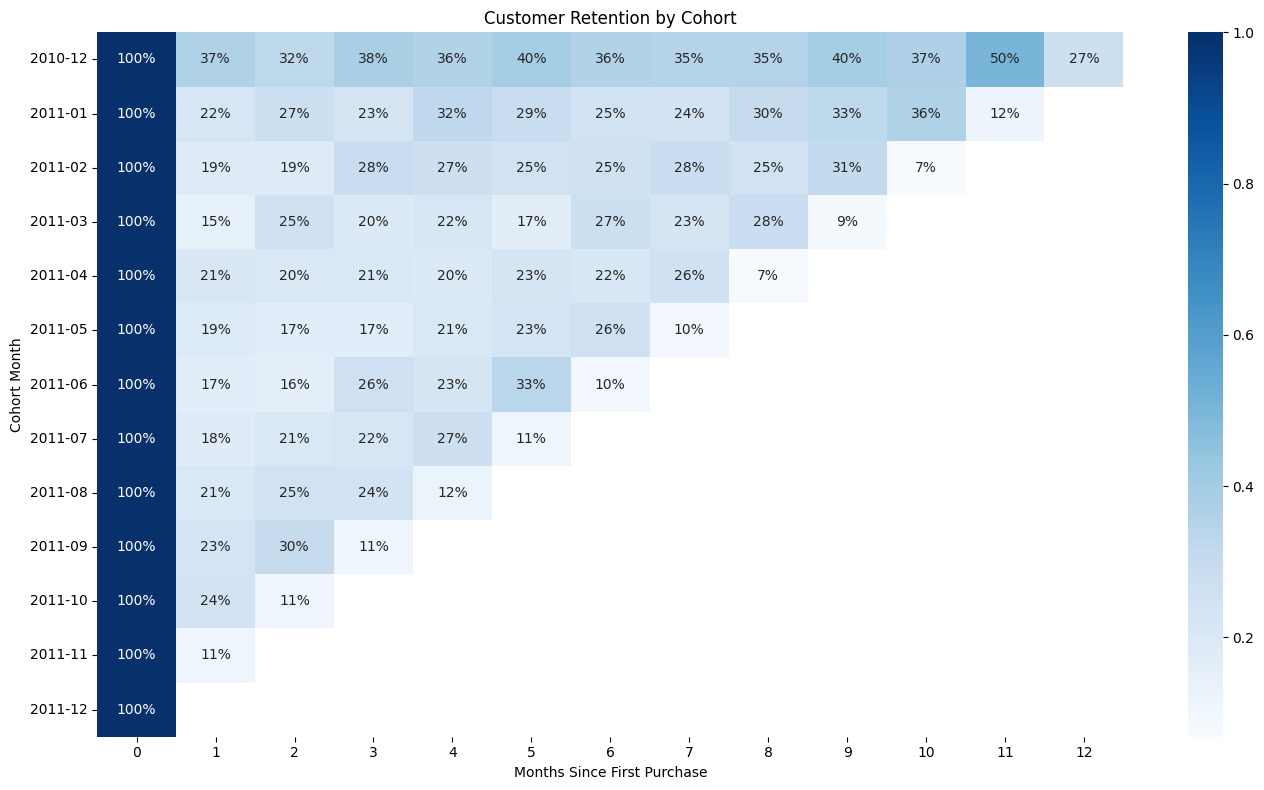

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.heatmap(
    retention_matrix,
    annot=True,
    fmt=".0%",
    cmap="Blues"
)

plt.title("Customer Retention by Cohort")
plt.xlabel("Months Since First Purchase")
plt.ylabel("Cohort Month")
plt.tight_layout()
plt.show()

## Export Cleaned Data

We export cleaned, analytics-ready datasets so that SQL analysis
and visualization notebooks can reproduce results independently.

In [36]:
# Export transaction-level tables
df_revenue.to_csv("../data/cleaned_revenue.csv", index=False)
df_customers.to_csv("../data/cleaned_customers.csv", index=False)

# Export summary tables (optional but recommended)
customer_summary.to_csv("../data/customer_summary.csv", index=False)
cohort_counts.to_csv("../data/cohort_counts.csv", index=False)

print("Exported:",
      "../data/cleaned_revenue.csv, ../data/cleaned_customers.csv, ../data/customer_summary.csv, ../data/cohort_counts.csv")

Exported: ../data/cleaned_revenue.csv, ../data/cleaned_customers.csv, ../data/customer_summary.csv, ../data/cohort_counts.csv
